In [1]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import matplotlib.image as mpimg
from tqdm import tqdm
from torchvision.transforms import transforms
from matplotlib.patches import Polygon
from numpy.random import choice,seed,random,uniform
%matplotlib inline

## Data Visualization

In [2]:
# training images and masks (we only visiual the training sets)
imgFile='./data/images/'
mskFile='./data/masks/'
all_files=os.listdir(mskFile)

In [6]:
if not os.path.exists('./data/imgs_no_msk.txt'):
    # filter out all the images with empty masks
    print('There are {} images in total.'.format(len(all_files)))
    empty_files=[]
    print('Searching all images with empty masks...')
    for file in tqdm(all_files):
        msk=plt.imread(mskFile+file).astype(np.uint8)
        if not msk.sum():
            empty_files.append(file)
    print('Complete!')
    print('There are {} images with empty masks.'.format(len(empty_files)))
    print('Saving the file names...')
    with open('./data/imgs_no_msk.txt','w') as f:
        for file in empty_files: 
            f.write(file+'\n')
        f.close()
    print('Complete!')
else:
    print('The file already exists, loading the file...')
    f=open('./data/imgs_no_msk.txt','r') 
    empty_files=[]
    for i in open('./data/imgs_no_msk.txt','r'):
        empty_files.append(f.readline().strip('\n'))
    print('Complete!')
    print('There are {} images with empty masks.'.format(len(empty_files)))

The file already exists, loading the file...
Complete!
There are 15231 images with empty masks.


In [7]:
# images statistics
files=[file for file in all_files if file not in empty_files] 
print('There are {} images with empty masks.'.format(len(empty_files)))
print('There are {} images with masks.'.format(len(files)))
print('#img_no_mask/#img_mask = {}.'.format(len(empty_files)/len(files)))

There are 15231 images with empty masks.
There are 3343 images with masks.
#img_no_mask/#img_mask = 4.556087346694586.


In [8]:
# randomly subsample n imgs
seed(2018)
n=16
subfiles=choice(all_files,n,replace=False).tolist()
imgs=[plt.imread(imgFile+file,'RGB') for file in subfiles]
msks=[plt.imread(mskFile+file,'RGB') for file in subfiles] # RBG image

In [9]:
# obtain the polygon for each msk
polygons=[]
for msk in msks:
    bimsk=cv2.cvtColor(msk,cv2.COLOR_RGB2GRAY).astype(np.uint8)
    polygon,_=cv2.findContours(bimsk,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    try:
        polygons.append(polygon[0].reshape(-1,2))
    except:
        polygons.append(np.zeros((1,2)).astype(np.uint8))

Text(0.5, 0.98, 'Sample Images')

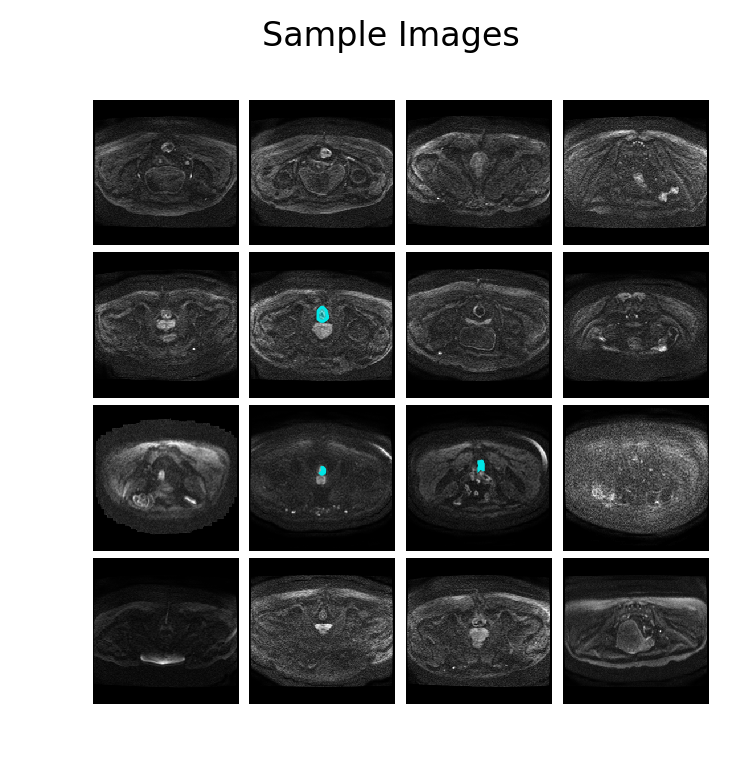

In [10]:
k=int(np.sqrt(n))
fig=plt.figure(figsize=(k,k),dpi=200)
fig.subplots_adjust(hspace=0.05,wspace=0.05)
# polygon color
color=[0,0.9,0.9]
for i in range(n):
    ax=fig.add_subplot(k,k,i+1)
    ax.imshow(imgs[i])
    try:
        ax.add_patch(Polygon(polygons[i],facecolor=None,linewidth=1,edgecolor=color,fill=False))
        ax.add_patch(Polygon(polygons[i],facecolor=color,alpha=0.5,linewidth=0))
    except:
        pass
    ax.axis('off')
fig.suptitle('Sample Images')

# Data Augmentation

In [109]:
# Reference: https://discuss.pytorch.org/t/torchvision-transfors-how-to-perform-identical-transform-on-both-image-and-target/10606/7
class DataAug(object):
    def __init__(self,filenms,img_path,msk_path,seed=2018):
        self.filenms=filenms
        self.img_path=img_path
        self.msk_path=msk_path
        self.seed=seed
        self.to_PIL=transforms.ToPILImage('RGB')
        self.imgs=[]
        self.msks=[]
        self.trans=False # indicate whether conduct transformation
        
    def _transform(self,imgPIL,mskPIL):
        # img and msk must in PIL format
        
        # Color Jitter
        # boost the performance on dark images
        # random pick brightness and contrast to make augmentation 
        if random()>0.5:
            ## brightness
            imgPIL=TF.adjust_brightness(imgPIL,uniform(0.4,1,1)[0])
        else:
            ## contrast
            imgPIL=TF.adjust_contrast(imgPIL,uniform(0.4,1,1)[0])
        
        # Rotation
        # uniformly rotate a degree between -5 and 5
        angle=10*uniform()-5
        imgPIL=TF.rotate(imgPIL,angle)
        mskPIL=TF.rotate(mskPIL,angle)
        
        return imgPIL,mskPIL
    
    def load(self):
        # load all images and masks
        nimg=len(self.filenms)
        print('Loading the images and masks...')
        for i in range(nimg):
            filenm=self.filenms[i]
            self.imgs.append(plt.imread(self.img_path+filenm,'RGB')[:,:,:3])
            self.msks.append(plt.imread(self.msk_path+filenm,'RGB')[:,:,:3])
        print('Complete!')
    
    def transform(self):
        print('Begin data augmentation...')
        seed(self.seed)
        for i in range(len(self.imgs)):
            imgPIL=self.to_PIL(self.imgs[i])
            mskPIL=self.to_PIL(self.msks[i])
            imgPIL,mskPIL=self._transform(imgPIL,mskPIL)
            self.imgs[i],self.msks[i]=np.array(imgPIL),np.array(mskPIL)
        print('Complete!')
        self.trans=True
    
    def show(self,n=4,set_seed=True):
        if n>len(self.filenms):
            raise ValueError('n should be smaller than {}'.format(len(self.filenms)))
        
        k=int(np.sqrt(n))
        if set_seed:
            seed(self.seed)
        ind=choice(len(self.msks),n,replace=False).tolist()
        
        # polygons
        polygons=[]
        for i in ind:
            bimsk=cv2.cvtColor(self.msks[i],cv2.COLOR_RGB2GRAY).astype(np.uint8)
            try:
                _,polygon,_=cv2.findContours(bimsk,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
                polygons.append(polygon[0].reshape(-1,2))
            except:
                polygon.append(np.array([0,0,0,0]).reshape(-1,2))
            
        
        # plot figure
        fig=plt.figure(figsize=(k,k),dpi=200)
        fig.subplots_adjust(hspace=0.05,wspace=0.05)
        # polygon color
        color=[0,0.9,0.9]
        for i in range(k**2):
            ax=fig.add_subplot(k,k,i+1)
            ax.imshow(self.imgs[ind[i]])
            try:
                ax.add_patch(Polygon(polygons[i],facecolor=None,linewidth=1,edgecolor=color,fill=False))
                ax.add_patch(Polygon(polygons[i],facecolor=color,alpha=0.5,linewidth=0))
            except:
                pass
            ax.axis('off')
        if self.trans:
            plt.suptitle('Sample Images \n (After Transformation)',fontsize=5)
        else:
            plt.suptitle('Sample Images \n (Before Transformation)',fontsize=5)

    def save(self):
        img_save_path,msk_save_path=self.img_path,self.msk_path
        
        imgs=os.listdir(img_save_path)
        aug_imgs=[img for img in imgs if 'a' in img]
        msks=os.listdir(msk_save_path)
        aug_msks=[msk for msk in msks if 'a' in msk]
        
        if aug_imgs or aug_msks:
            print('Cleaning the outdated image augmentations...')
            for aug_img,aug_msk in zip(aug_imgs,aug_msks):
                    os.remove(img_save_path+aug_img)
                    os.remove(msk_save_path+aug_msk)
            print('Complete!')
        
        print('Saving the images and masks...')
        for i,(img,msk) in enumerate(zip(self.imgs,self.msks)):
            filenm='a.'.join(self.filenms[i].split('.')) # 'a' means augmentation 
            plt.imsave(img_save_path+filenm,img)
            plt.imsave(msk_save_path+filenm,msk)
        print('Complete!')

In [110]:
# training images and masks (we only visiual the training sets)
# Determine the augmented figures
seed(2018)
r=0.05 # augmentation ratio
naug=np.int(r*len(empty_files))
aug_files=choice(empty_files,naug,replace=False).tolist()

Loading the images and masks...
Complete!
Begin data augmentation...
Complete!


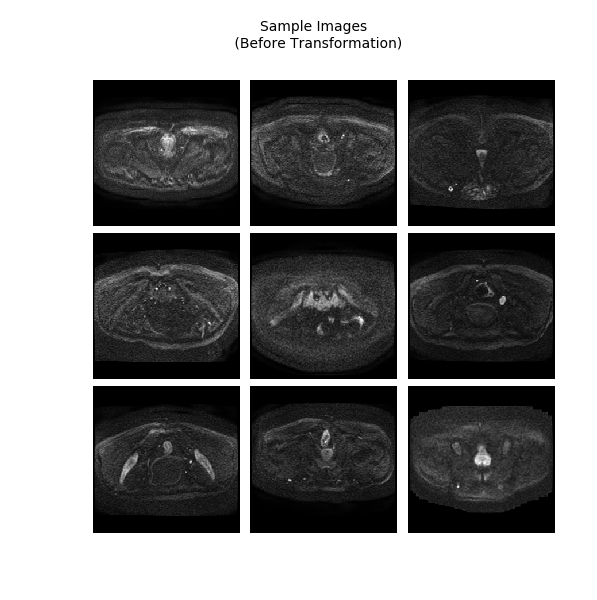

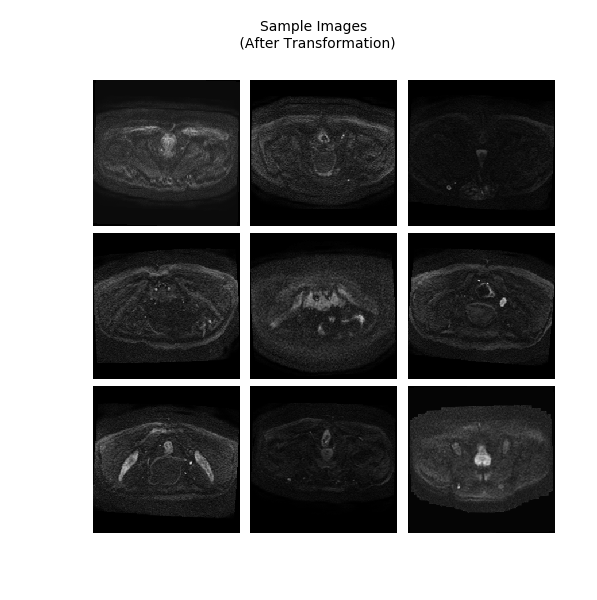

In [111]:
# Data Augmentation
DA=DataAug(aug_files,imgFile,mskFile)
DA.load()
DA.show(9)
DA.transform()
DA.show(9)